In [1]:
from gwpy.timeseries import TimeSeries
from numpy import *
from numpy.fft import fft, ifft
from scipy import signal

In [110]:
# I haven't really sorted out how GWPY's plotting interacts with Jupyter
# This notebook works on my laptop, but we need some wider testing
%matplotlib inline
import matplotlib.pyplot as plt

# Building a simple line tracker

We're going to write a simple code to track the amplitude and phase of a line with a known frequency. We'll force the frequency to have four digits of precision, so any any line we track will have a periodicity of 10,000 seconds. That way, the meaning of the phase can be defined independent of the start time of the data. It will be defined as the phase of the line at any GPS time ending in 0000.

## The method

We'll do everything with zero-phase filters. That's easy as long as we use FIR filters. We'll apply the filter in the frequency domain, which is more efficient for long signals. 

1. Heterodyne the data (multiply by e^{i 2 pi f t}), where t is the time as an offset of GPS xxxxxx0000.
2. Now the line is effectively at zero frequency. Lowpass the data to remove everything not near the line.
3. Take the amplitude and phase of the result. These are the amplitude and phase of the line.

## Zero-phase filtering

To do the lowpass in a careful way, we'll use an FIR filter. This allows us to easily control the length of the impulse response, so we know how much data at the edges of the signal is corrupted. Instead of convolving the filter in the time domain, we FFT it and multiply in the frequency domain. The FIR filter will be pure linear-phase (identical to a time delay). By taking the absolute value, we remove the time delay, and the response of the filter will be symmetric around t=0.

In [3]:
def fd_lowpass(impulse_len_sec, f_lowpass, data_tlen_sec, sample_rate):
    """Make a zero-phase lowpass filter in the frequency domain, with a specified impulse response length"""
    # We're going to make the filter symmetric around its center
    # The TD version of the filter can be twice the length of the impulse response that we're aiming for
    numtaps=int(2.*impulse_len_sec*sample_rate)
    nyquist=float(sample_rate)/2.
    win=signal.firwin(numtaps, f_lowpass/nyquist)
    # Now pad with zeros to match the length of the data
    win.resize(int(data_tlen_sec*sample_rate))
    # Take the absolute value to make it zero-phase
    return abs(fft(win))

## The line tracker

In [73]:
def make_line(data, f_line, amplitude=1., phase=0.):
    f_line = round(f_line,4)
    ref_time = int(data.epoch.gps) % 10000
    times = arange(len(data))/float(data.sample_rate.value) + ref_time
    return amplitude*exp(1.j*(2.*pi*f_line*times+phase))
    
def track_line(data, f_line, f_bw, impulse_len_sec):
    srate = data.sample_rate.value
    duration = data.duration.value
    
    # Heterodyne the data with the line - make frequency negative to get the conjugate
    heterodyned = data.value*make_line(data, -f_line)
    
    # Apply the filter by: FFT the data, multiply by FD lowpass filter, IFFT back to TD
    # The factor of two is because the line gets split to f=0 and f=2f_line
    fdata = fft(heterodyned) * fd_lowpass(impulse_len_sec, f_bw, duration, srate)
    downsampled_data = 2.*ifft(fdata)
    # FIXME: Convert back to gwpy.TimeSeries
    
    # The edges of the data corrupt the filter for a length equal to the impulse response
    # So we remove that part of the data
    corrupt_idx = int(impulse_len_sec*srate)
    # FIXME: Return the amplitude and phase rather than the complex timeseries?
    return downsampled_data[corrupt_idx:-corrupt_idx]

## Make some test data

Just put in a single line to make sure the amplitude and phase come out right.

In [93]:
test_data = TimeSeries(zeros(4096*128), sample_rate=4096, epoch=0)
test_data += 1.*cos(2.*pi*100.*arange(4096*128)/4096. - pi/3.)
test_line_track = track_line(test_data, 100., 0.0625, 16)

In [94]:
print median(abs(test_line_track))
print median(unwrap(angle(test_line_track)))*180/pi

1.0
-59.9999999999


## Now try it out on some real data

The code below will get the data from NDS2 the first time, then cache it in a file. Make sure you have a Kerberos ticket the first time you run. The automatic prompt for user and password in gwpy doesn't work in a Jupyter notebook, at least for me.

In [108]:
data_fname='H1-GDS_HOFT-1126259206-512.hdf'
try:
    data = TimeSeries.read(data_fname)
except:
    data = TimeSeries.fetch('H1:GDS-CALIB_STRAIN', 1126259206, 1126259206+512)
    data.write(data_fname)

In [103]:
data_line_track = track_line(data, 60., 0.0625, 16)

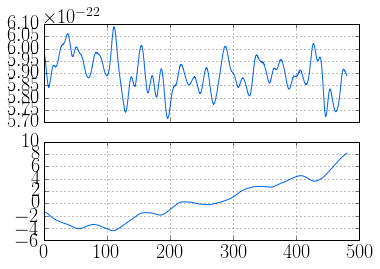

In [106]:
data_times = arange(len(data_line_track))/data.sample_rate.value
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(data_times,abs(data_line_track))
ax[1].plot(data_times,unwrap(angle(data_line_track)))

## Subtract the calibration lines

Now we find the amplitude and phase of a set of lines and subtract them from the data.

In [96]:
def remove_lines(data, f_line_list, f_bw=0.0625, impulse_len_sec=16):
    result = data.copy()
    for f_line in f_line_list:
        cplx_line = track_line(data, f_line, f_bw, impulse_len_sec)
        amplitude = median(abs(cplx_line))
        phase = median(unwrap(angle(cplx_line)))
        result -= make_line(data, f_line, amplitude, phase).real
    return result

In [75]:
cal_lines = {}
cal_lines['H1'] = [35.9, 36.7, 37.3, 331.9] # Is there a PcalX line at 3001.3?
cal_lines['L1'] = [33.7, 34.7, 35.3, 331.3] # Read off a spectrum

In [80]:
test_removal = remove_lines(data, cal_lines[data.channel.ifo])

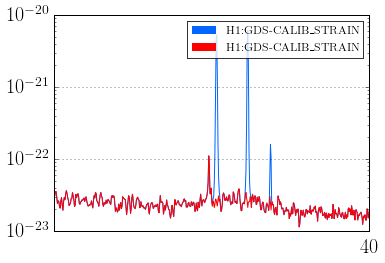

In [109]:
gwplt=data.asd(64,48).plot()
gwplt.gca().plot(test_removal.asd(64,48))
gwplt.gca().set_xlim(32,40)
gwplt.gca().set_ylim(1e-23,1e-20)
gwplt.show()

### Below is a test of the impulse response

Not very well documented at the moment. Worth keeping?

In [183]:
tst=zeros(int(tlen_sec*srate), dtype=float64)
tst[len(tst)/2]=1.
tst1=ifft(fft(tst)*fd_lowpass(4,4,tlen_sec,srate))
tst2=ifft(fft(tst)*fd_lowpass(16,4,tlen_sec,srate))

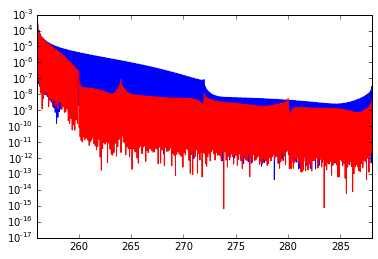

In [184]:
plt.plot(arange(len(tst2))/srate, abs(tst2), c='b')
plt.plot(arange(len(tst1))/srate, abs(tst1), c='r')
plt.xlim(tlen_sec/2.,tlen_sec/2.+32)
plt.yscale('log')